# Algorithms Implementation

This section is designed for the implementation of the paper of Kleindessner et. al : Guarantees for Spectral Clustering with Fairness Constraints (arXiv:1901.08668) in Python.

Author : Maxime Fontana

### Unnormalised Spectral Clustering

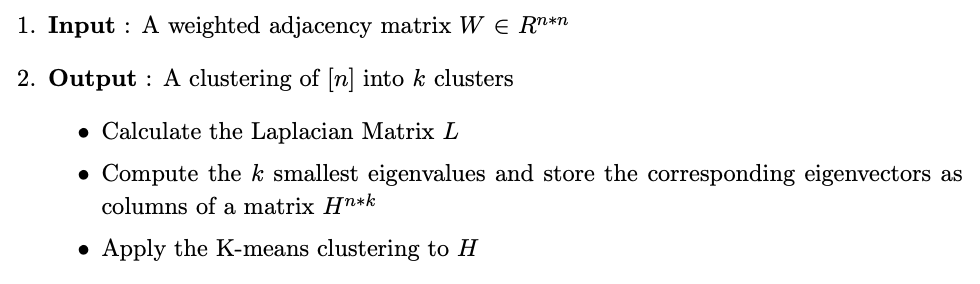

This algorithm is also referred to as "Algo 1" in the paper

In [7]:
def un_spectral(G, k, metric=False):
    """
    @params G : Input Graph
            k : Number of clusters
    """
    
    # We get the laplacian Matrix from the graph's adjacency matrix
    laplacian_matrix = nx.laplacian_matrix(G)
    
    # Compute the EigenVectors/Values 
    e, v = np.linalg.eig(laplacian_matrix.toarray())
    
    # Sort corresponding eigenvectors w.r.t respective eigenvalues
    # Note here that v[:,i] is the eigenvector corresponding to e[i]
    v, e = v[:,np.argsort(e)], e[np.argsort(e)]

    # Apply K-means to the k-smallest eigenvectors
    km = KMeans(init='k-means++', n_clusters=k, random_state = 2)
    km.fit(v[:,:k])
    
    if metric:
        print("Silhouette Score :", metrics.silhouette_score(nx.to_numpy_matrix(G), km.labels_))
        print("Algo. 1 RatioCut :", ratio_cut(laplacian_matrix, v[:,:k]))
        
    return km.labels_

### Unnormalised Fair Spectral Clustering

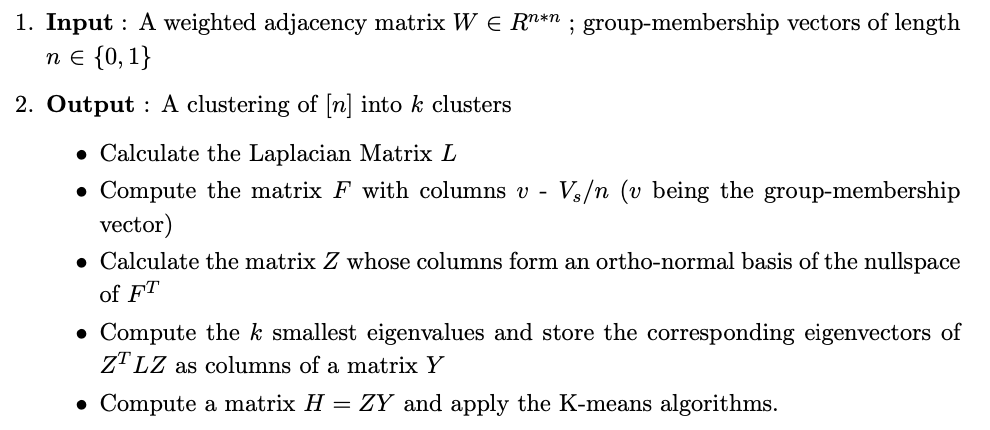

This algorithm is also referred to as "Algo 2" in the paper.

In [8]:
# We implement here a few help functions for the implement of the algorithm in the next cell

# !!! NEEDS OPTIMISATION (Like numpy is not used everywhere...)

def get_Vs(array): 
    counter = 0
    for i in range(len(array)):
        if array[i] == 1:
            counter += 1
    
    return counter

def get_N(array): 
    return len(array)

def n_ones_vector(array): 
    return np.ones(len(array))

def build_matrix_F(G, labels):
    """
    @params G : Input Graph
            labels : number of clusters
            labels : output of the 'unfair' Unnormalised SC algo
    """
    
    num_samples = len(G) 
    F = []
    
    for i in range(max(labels)):
        column = [0] * len(G)
        for y in range(len(labels)):
            if labels[y] == i:
                column[y] = 1
        column = np.asarray(column - ((get_Vs(column) / get_N(column)) * n_ones_vector(column)))
        F.append(column)
            
    return np.transpose((np.asarray(F)))


In [9]:
def un_spectral_fair(G, k, labels, metric=False):
    """
    @params G : Graph
            k : number of clusters
            labels : output of the 'unfair' Unnormalised SC algo
    """
    
    # Get the laplacian
    laplacian_matrix = nx.laplacian_matrix(G)
    
    # Build the matrix F representing membershipness.
    F = build_matrix_F(G, labels)
    
    # Build the Matrix Z thanks to matrix F
    Z = scipy.linalg.null_space(np.transpose(F))
    
    # Perform the 3-Matrix multiplication
    LZ = np.matmul(laplacian_matrix.toarray(), Z)
    TZ = np.transpose(Z)
    fed_matrix = np.matmul(TZ, LZ)
    
    # Take the orthogonal eigenvetors as 
    e, v = np.linalg.eigh(fed_matrix)
    
    # Sort corresponding eigenvectors w.r.t respective eigenvalues
    # Note here that v[:,i] is the eigenvector corresponding to e[i]
    v, e = v[:,np.argsort(e)], e[np.argsort(e)]
    
    # Apply K-means (random state to always produce the same labels)
    km = KMeans(init='k-means++', n_clusters=k, random_state = 2)
    
    # Create Matrix H and fit it to the K-means algorithm
    H = np.matmul(Z, v[:, :k])
    km.fit(H)
    
    if metric:
        print("Algo. 2 RatioCut :", ratio_cut(laplacian_matrix, H))
        
    return km.labels_